In [10]:
import numpy as np 
import sympy as sy
import matplotlib.pyplot as plt
import tensorflow as tf 
import random
from IPython.core.interactiveshell import InteractiveShell
import warnings 
InteractiveShell.ast_node_interactive = "all"
warnings.filterwarnings("ignore")

The convolution between two continous signals over the real number line is given by: 

\begin{equation}
s(t)= (f * g)(t) = \int_{-\infty}^{+\infty} f(\tau)g(t-\tau)d\tau 
\end{equation}

For the discrete case, that is where we consider the the domain on the integer number line:

\begin{equation}
s(t) = \sum_{\tau \in \mathbb{Z}} f(\tau)g(t-\tau)
\end{equation}

In a fully connected dense layer, we have the output of a layer as:

\begin{equation}
    y_j = \phi \big(\sum_{i} w_{ji} x_i + b_{j} \big)
\end{equation}


In a convolutional layer, the output is instead:

\begin{equation}
y = \sum(I * K + b)  
\end{equation}

Here:
I is the input _feature map_ <br>
K is the _kernel_ <br>
b is the _additive bias_ <br>
and we sum over all convolution of our feature map and kernel. 

consider the following example: <br>
An input feature map, I, of dimensions (4 x 4 x 1); a **single channel** ( - x - x **1**) <br>
And a Kernel, K, of dimensions (3 x 3 x 1 x 1); a **single filter** (- x - x - x **1**)

In [11]:
I = sy.Matrix([ [0,1,2,8],
                [5,2,9,2],
                [3,6,1,0],
                [2,4,9,6]])
print("Input feature map, I:")
I

Input feature map, I:


Matrix([
[0, 1, 2, 8],
[5, 2, 9, 2],
[3, 6, 1, 0],
[2, 4, 9, 6]])

In [12]:
K = sy.Matrix( [ [1,5,2],
                [2,7,3], 
               [2,0,2] ] )
print("Kernel, K:")
K

Kernel, K:


Matrix([
[1, 5, 2],
[2, 7, 3],
[2, 0, 2]])

Instead of sweeping with our kernel K across the in input feature map I, lets reshape I into a long vector:

In [13]:
Ir = sy.Matrix(np.array(I).reshape(-1))
print("Reshaped feature map: ")
Ir

Reshaped feature map: 


Matrix([
[0],
[1],
[2],
[8],
[5],
[2],
[9],
[2],
[3],
[6],
[1],
[0],
[2],
[4],
[9],
[6]])

In [14]:
def unroll_kernel(K, unrolled_length, num_steps):
    rows = []
    K_size = np.array(K).reshape(-1).shape[0]
    unrolled_length_var = unrolled_length
    i = 0
    for idx,row in enumerate(range(num_steps)):
        if idx <= 1:
            rows.append(
                np.hstack(
                (np.zeros(idx, dtype="int"),
                 np.array(K).reshape(-1),
                 np.zeros(unrolled_length - K_size - idx , dtype="int"))
            ))
        else:
            i+=1
            if idx == 3:
                i+=1
            rows.append(
                np.hstack(
                (np.zeros(unrolled_length - K_size - idx + i , dtype="int"),
                 np.array(K).reshape(-1),
                 np.zeros(idx-i, dtype="int") )
                 ))
    return np.vstack(rows)

print("Unrolled kernel Kr:")
Kr = sy.Matrix(unroll_kernel(K, 16, 4))
    


Unrolled kernel Kr:


The convolution can now be described as matrix multiplication: 

In [15]:
sy.MatMul(Kr,Ir)

Matrix([
[1, 5, 2, 2, 7, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 5, 2, 2, 7, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 5, 2, 2, 7, 3, 2, 0, 2, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 5, 2, 2, 7, 3, 2, 0, 2]])*Matrix([
[0],
[1],
[2],
[8],
[5],
[2],
[9],
[2],
[3],
[6],
[1],
[0],
[2],
[4],
[9],
[6]])

In [16]:
sy.MatMul(Kr,Ir).doit()

Matrix([
[90],
[94],
[66],
[57]])

And finally, the output vector is reshaped into a 2 dimensional feature map:

In [17]:
sy.Matrix(np.array(sy.MatMul(Kr,Ir).doit()).reshape((2,2)))

Matrix([
[90, 94],
[66, 57]])

In [18]:
import numpy as np 

Question:
_how do I know the output dimensions before hand_? 

\begin{equation}
O_x = \frac{(I_x  - K_x +2P)}{S+1}
\end{equation}

\begin{equation}
O_y = \frac{(I_y  - K_y +2P)}{S+1}
\end{equation}
\begin{equation}
O_z = N
\end{equation}

\begin{equation}
S: \text{Stride} 
\end{equation}
\begin{equation}
P: \text{Padding} 
\end{equation}
\begin{equation}
N: \text{Number of Filters} 
\end{equation}
\begin{equation}
K_{x/y}: \text{Kernel Dimensions} 
\end{equation}
\begin{equation}
I_{x/y}: \text{Input Dimensions} 
\end{equation}

In the previous example: Assumed a feature map of only **1 channel**. Images are usually 3 channels; RGB.
<br>
Also assumed to have only **1 filter**. But you are free to choose the amount of filters. 
<br>
Lets define the hyperparameters of a convolutional layer:
- _Kernel Size_  (above this was 4x4)
- _Number of Filters_ (above this was 1)
- _Padding_ (above this was set to 0) 
- _Stride_ (above this was 1)

<br>
The total number of learnable parameters on a convolutional layer are:

\begin{equation}
n_{params} = ( K_x  K_y O_z +1 )I_z 
\end{equation}
\begin{equation}
K_x, K_y: \text{Kernel dimensions}
\end{equation}
\begin{equation}
O_z: \text{Output depth}
\end{equation}
\begin{equation}
I_z: \text{input depth} 
\end{equation}

Note the additional 1 is for the additive bias.

### Types of Convolutions
This is nowhere an exhaustive list. But these are the most common ones you'll need.
- Vanilla Convolutions 
- Pointwise Convolutions 
- Depthwise Convolutions 

### Vanilla Convolutions
Suppose we have the image:

Dimensions of Tegerdine: (194, 194, 3)
Dimensions of Teger's red channel: (194, 194)
Dimensions of Teger's green channel: (194, 194)
Dimensions of Teger's blue channel: (194, 194)


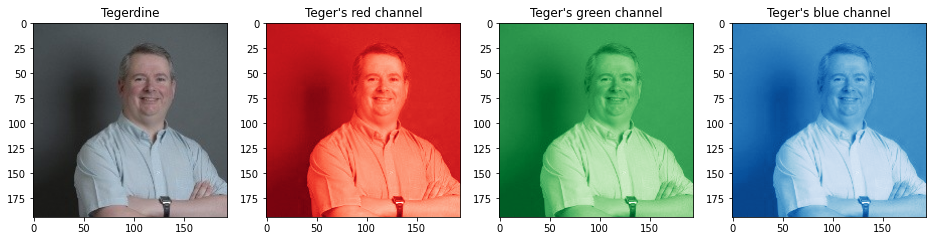

In [19]:

def get_teger():
    return plt.imread("media/convsOnTegerdine.jpeg") /255.

def plot_teger():
    titles = ['Tegerdine', 'Teger\'s red channel', 'Teger\'s green channel', 'Teger\'s blue channel']
    cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]
    fig, axes = plt.subplots(1, 4, figsize=(16,4))

    # normal the pixel values
    tegers = get_teger() 
    objs = zip(axes, (tegers, *tegers.transpose(2,0,1)), titles, cmaps)

    for ax, channel, title, cmap in objs:
        print(f"Dimensions of {title}: {channel.shape}")
        ax.imshow(channel, cmap=cmap)
        ax.set_title(title)
#         ax.set_xticks(())
#         ax.set_yticks(())

plot_teger()   

In [106]:
"get_teger".capitalize()

'Get_teger'

With vanilla convos, we have a learnable kernel **per teger channel**. Once the convo has been applied, we sum up the convos, apply a bias, and **sum** the output.
<br>
This is simulated below via random initialisations of a kernel per channel and using the tensorflow 2D convo layer. 

In [107]:
def get_random_kernel(n,s=10):
    names = ["zero and ones", "normal sample", "off diag"]
    pat = [np.ones((1,s)),
        np.zeros((1,s)),
        np.ones((1,s))]
    stack = [x for y in [pat for _ in range(4)] for x in y][:s]
    # print("shape of zeros pat list: ", stack.shape)
    row_k = np.vstack(stack) *0.1
    col_k = np.random.sample(size=(s,s))
    diag_k = np.diag(np.arange(3,3+s-1), k=1) + np.diag(np.arange(8,s-1+8), k=-1)
    ks = [row_k,col_k,diag_k]
    ks = list(zip(names,ks))

    # choice_indices = np.random.choice(len(ks), 1, replace=True, p=[0.3,0.4,0.3])
    choices =ks[n] #   [ks[i] for i in choice_indices]
    from pprint import pprint 
    print("using kernel")
    print(choices[0])
    pprint(choices[1].shape)

    return choices[1], choices[0]
    # return random.sample([row_k,col_k,diag_k], k=1)[0]
    
def apply_vanilla_conv(kernel,slice_dim):        
    teger_channel = get_teger().transpose(2,0,1)[slice_dim]
    
    # into teger slice needs to be of dimensions: batch_shape + [in_height, in_width, in_channels]
    # adding batch dim to teger slice and chanel dim to teger slice
    teger_channel = teger_channel[np.newaxis,...][...,np.newaxis]
    kernel = np.array(kernel)[...,np.newaxis][...,np.newaxis]
    # and kernel [filter_height, filter_width, in_channels, out_channels]
    kernel = tf.constant(kernel, dtype=tf.float32)
    
    x = tf.constant(teger_channel, dtype=tf.float32)
    
    print("Kernel shape")
    print(kernel.shape)
    print("tegger channel; x.shape")
    print(x.shape)
    teger_convolved = tf.nn.conv2d(
                input=x,
            filters=kernel, strides=[1,], padding='VALID', data_format="NHWC")
    
    return teger_convolved 

def tf_to_numpy(x):
    return x.numpy().transpose(1,2,0,3)[:,:,0,0]


def plot_teger_new(convoled_list,n ):
    titles = ['Tegerdine',
              'Teger\'s convoled red channel',
              'Teger\'s convoled green channel',
              'Teger\'s convolved blue channel',
             'Teggerdine\'s post convolution']
    
    cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r, None]
    fig, axes = plt.subplots(5,1, figsize=(10,50))
    
    tegers = get_teger().transpose(2,0,1)[0]
    objs = zip(axes, (tegers, *convoled_list, sum(convoled_list) ), titles, cmaps)
    i = 0
    for ax, channel, title, cmap in objs:
        print(f"Dimensions of {title}: {channel.shape}")
        if "Tegerdine" == title:
            ax.imshow(get_teger(), cmap=None)
        else:
            ax.imshow(channel, cmap=cmap)
        if "channel" in title:
            t = n[i]
            i+=1
            tt = t.capitalize()
            ax.set_title(f"{tt} kernel: "+title)
        else:
            ax.set_title(title)
#         ax.set_xticks(())
#         ax.set_yticks(())

Demonstrating the vanilla 

using kernel
zero and ones
(10, 10)
using kernel
normal sample
(10, 10)
using kernel
off diag
(10, 10)
Kernel shape
(10, 10, 1, 1)
tegger channel; x.shape
(1, 194, 194, 1)
Kernel shape
(10, 10, 1, 1)
tegger channel; x.shape
(1, 194, 194, 1)
Kernel shape
(10, 10, 1, 1)
tegger channel; x.shape
(1, 194, 194, 1)
Dimensions of Tegerdine: (194, 194)
Dimensions of Teger's convoled red channel: (185, 185)
Dimensions of Teger's convoled green channel: (185, 185)
Dimensions of Teger's convolved blue channel: (185, 185)
Dimensions of Teggerdine's post convolution: (185, 185)


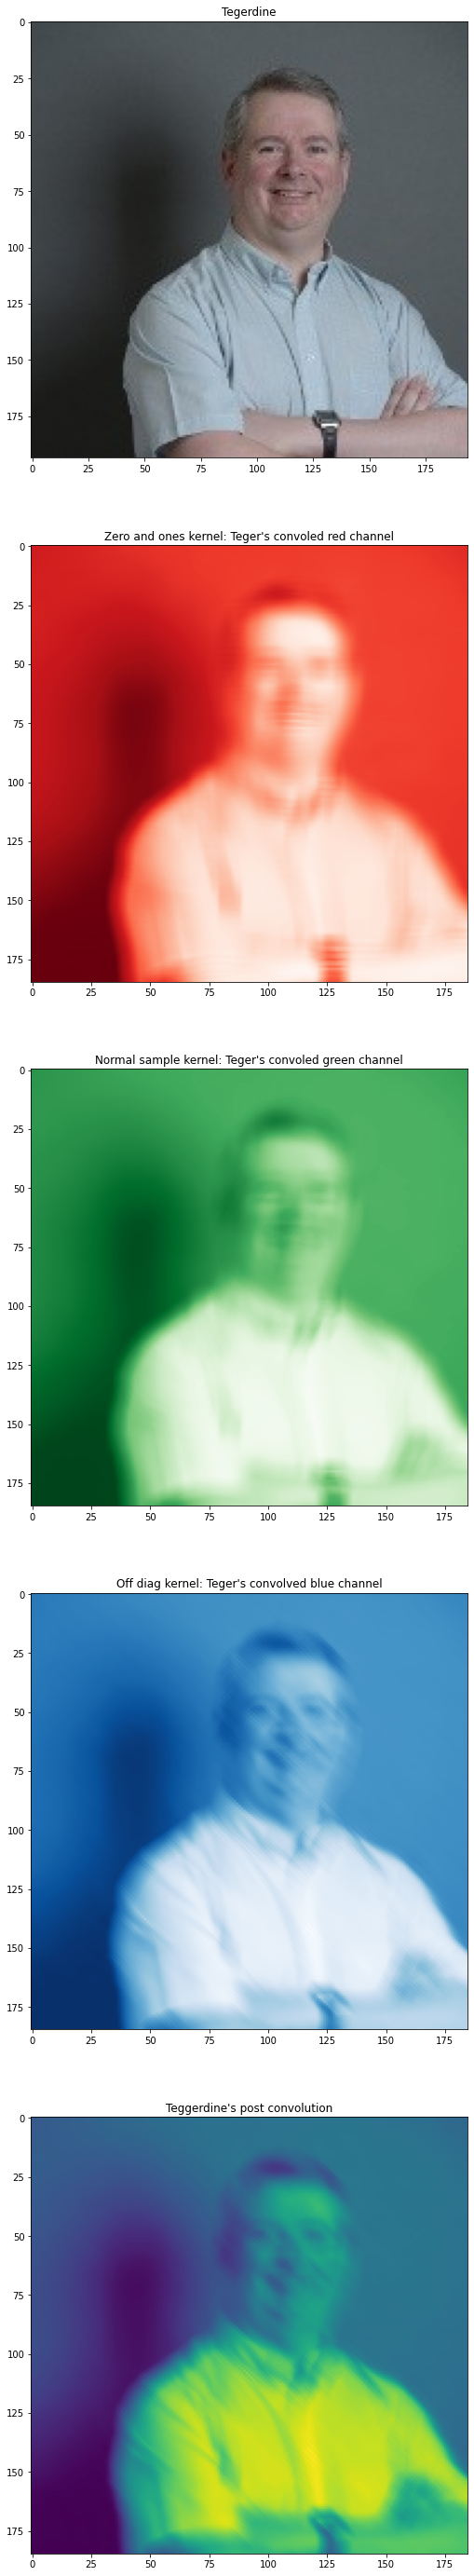

In [108]:
def plot_vanilla_conv():
    kernels = [get_random_kernel(x) for x in range(3)] 
    convoled_teger_sliced = [ ]
    n = []
    for idx, k in enumerate(kernels):
        
        convoled_teger_sliced.append(
            tf_to_numpy(apply_vanilla_conv(k[0],idx))
        )
        n.append(k[1])
    plot_teger_new(convoled_teger_sliced, n)
 
plot_vanilla_conv()